# Code

In [8]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image,
    as illustrated in Figure 1.
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """

    ### START CODE HERE ### (≈ 1 line)
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=(0, 0))
    ### END CODE HERE ###

    return X_pad

In [0]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation
    of the previous layer.
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """

    ### START CODE HERE ### (≈ 2 lines of code)
    # Element-wise product between a_slice and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev, W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z + float(b)
    ### END CODE HERE ###

    return Z

# Forward Pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume:

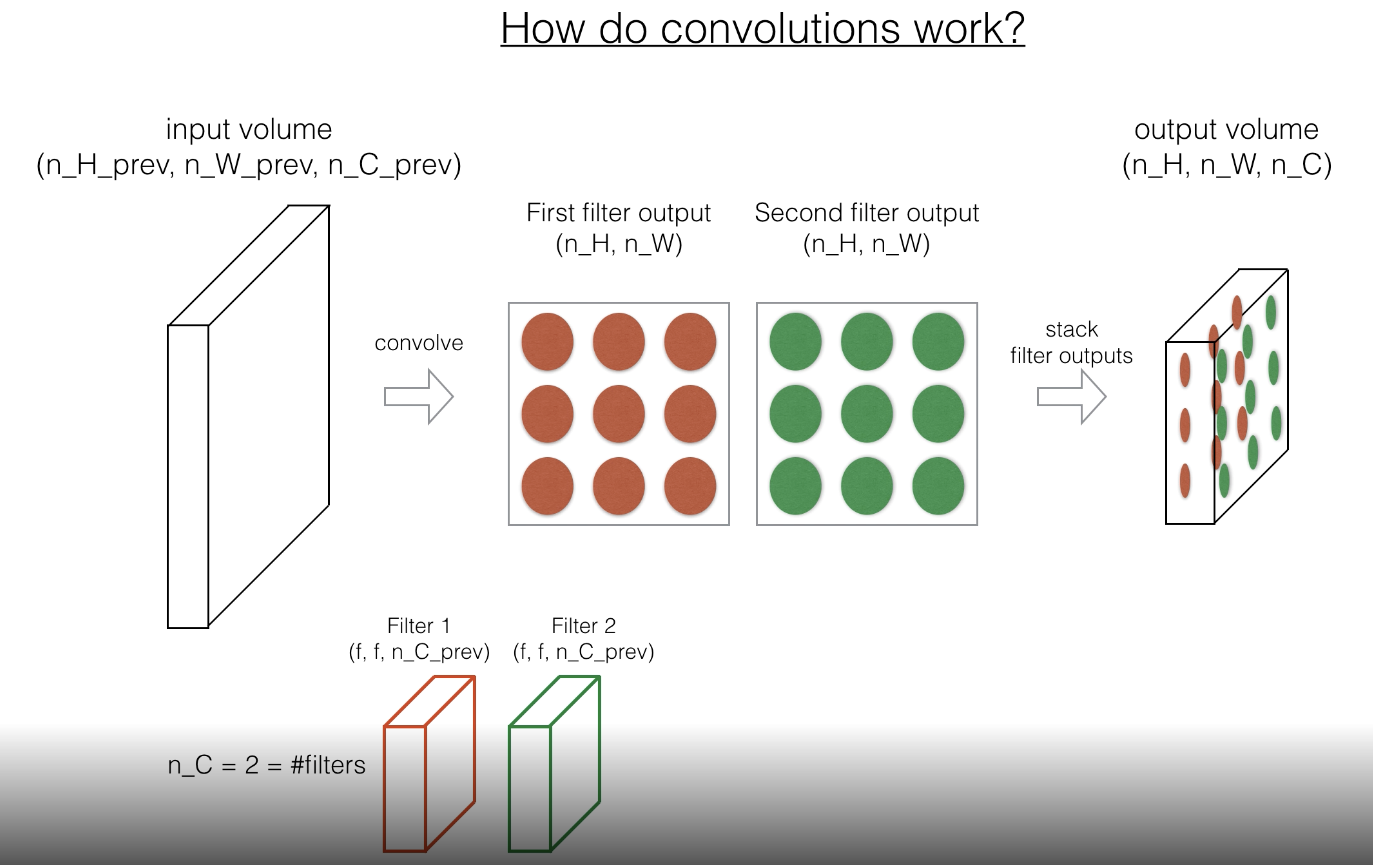

**Exercise**: 
Implement the function below to convolve the filters `W` on an input activation `A_prev`.  
This function takes the following inputs:
* `A_prev`, the activations output by the previous layer (for a batch of m inputs); 
* Weights are denoted by `W`.  The filter window size is `f` by `f`.
* The bias vector is `b`, where each filter has its own (single) bias. 

Finally you also have access to the hyperparameters dictionary which contains the stride and the padding. 

**Hint**: 
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels.  
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.
2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corner can be defined using h, w, f and s in the code below.


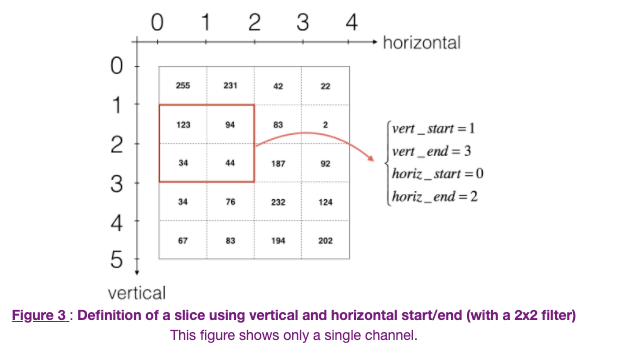

**Reminder**:
The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

For this exercise, we won't worry about vectorization, and will just implement everything with for-loops.

#### Additional Hints if you're stuck


* You will want to use array slicing (e.g.`varname[0:1,:,3:5]`) for the following variables:  
  `a_prev_pad` ,`W`, `b`  
  Copy the starter code of the function and run it outside of the defined function, in separate cells.  
  Check that the subset of each array is the size and dimension that you're expecting.  
* To decide how to get the vert_start, vert_end; horiz_start, horiz_end, remember that these are indices of the previous layer.  
  Draw an example of a previous padded layer (8 x 8, for instance), and the current (output layer) (2 x 2, for instance).  
  The output layer's indices are denoted by `h` and `w`.  
* Make sure that `a_slice_prev` has a height, width and depth.
* Remember that `a_prev_pad` is a subset of `A_prev_pad`.  
  Think about which one should be used within the for loops.

In [0]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """

    ### START CODE HERE ###
    # Retrieve dimensions from A_prev's shape (≈1 line)
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape

    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']

    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev - f + (2 * pad)) / stride + 1)
    n_W = int((n_W_prev - f + (2 * pad)) / stride + 1)

    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros((m, n_H, n_W, n_C))

    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)

    for i in range(m):  # loop over the batch of training examples
        a_prev_pad = A_prev[i]  # Select ith training example's padded activation
        for h in range(n_H):  # loop over vertical axis of the output volume
            for w in range(n_W):  # loop over horizontal axis of the output volume
                for c in range(n_C):  # loop over channels (= #filters) of the output volume

                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = stride * h
                    vert_end = stride * h + f
                    horiz_start = stride * w
                    horiz_end = stride * w + f

                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])

    ### END CODE HERE ###

    # Making sure your output shape is correct
    assert (Z.shape == (m, n_H, n_W, n_C))

    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)

    return Z, cache

In [11]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


# Forward Pooling

The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The two types of pooling layers are: 

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.

- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.


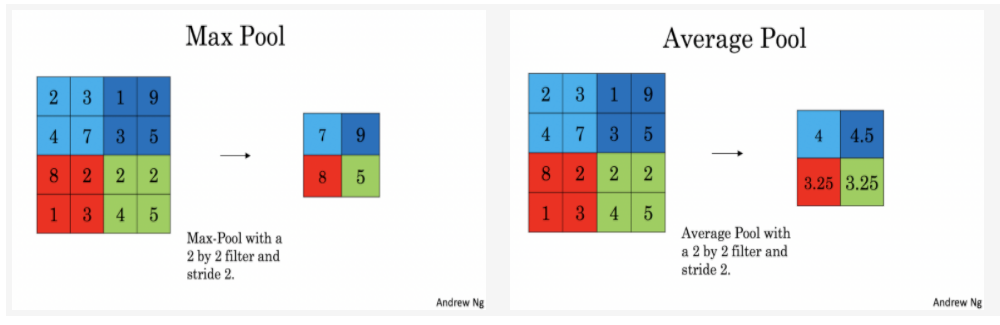

These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size $f$. This specifies the height and width of the $f \times f$ window you would compute a *max* or *average* over. 

### Forward Pooling
Now, you are going to implement MAX-POOL and AVG-POOL, in the same function. 

**Exercise**: Implement the forward pass of the pooling layer. Follow the hints in the comments below.

**Reminder**:
As there's no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [0]:
def pool_forward(A_prev, hparameters, mode="max"):
    """
    Implements the forward pass of the pooling layer
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters
    """

    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]

    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev

    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))

    ### START CODE HERE ###
    for i in range(m):  # loop over the training examples
        for h in range(n_H):  # loop on the vertical axis of the output volume
            for w in range(n_W):  # loop on the horizontal axis of the output volume
                for c in range(n_C):  # loop over the channels of the output volume

                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = stride * w
                    vert_end = stride * w + f
                    horiz_start = stride * h
                    horiz_end = stride * h + f

                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]

                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)

    ### END CODE HERE ###

    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)

    # Making sure your output shape is correct
    assert (A.shape == (m, n_H, n_W, n_C))

    return A, cache

In [13]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.14472371 0.90159072 2.10025514]
   [1.13162939 1.51981682 2.18557541]]

  [[1.74481176 1.46210794 1.65980218]
   [1.14472371 0.90159072 1.65980218]
   [1.13162939 1.51981682 2.18557541]]

  [[1.74481176 1.6924546  1.65980218]
   [1.14472371 1.6924546  1.65980218]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [1.96710175 0.84616065 1.27375593]
   [1.96710175 0.86888616 1.27375593]]

  [[0.69803203 0.84616065 1.2245077 ]
   [1.96710175 0.84616065 1.23616403]
   [1.96710175 0.86888616 1.23616403]]

  [[0.69803203 1.12141771 1.2245077 ]
   [1.62765075 1.12141771 1.2245077 ]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [-3.82680519e-01  2.32579951e-01  6.25997903e-01]]

  [[ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [

In [14]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.13162939 1.51981682 2.18557541]]

  [[1.74481176 1.6924546  1.65980218]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [1.96710175 0.86888616 1.27375593]]

  [[0.69803203 1.12141771 1.2245077 ]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [-0.38268052  0.23257995  0.6259979 ]]

  [[ 0.12893444  0.22242847  0.1250676 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.42944926  0.08446996 -0.27290905]]

  [[ 0.02030094  0.14141479 -0.01231585]
   [ 0.15077452  0.28911175  0.00123239]]]]
